In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

In [4]:
olympic_data = pd.read_csv('../../csv/olympic_data_cleaned.csv')
olympic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   game_year         2889 non-null   int64 
 1   country_name      2889 non-null   object
 2   total_medals      2889 non-null   int64 
 3   gold_medals       2889 non-null   int64 
 4   silver_medals     2889 non-null   int64 
 5   bronze_medals     2889 non-null   int64 
 6   sports            2889 non-null   int64 
 7   epreuves          2889 non-null   int64 
 8   game_part         2889 non-null   int64 
 9   prec_game_medal   2889 non-null   int64 
 10  prec_game_gold    2889 non-null   int64 
 11  prec_game_silver  2889 non-null   int64 
 12  prec_game_bronze  2889 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 293.5+ KB


In [5]:
X = olympic_data.drop(columns=['total_medals'])
y = olympic_data['total_medals']

# Identifier les colonnes non numériques

In [6]:
non_numeric_columns = X.select_dtypes(include=['object']).columns

# Encodage des colonnes non numériques

In [7]:
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Vérifier les valeurs manquantes et les imputer avec la moyenne

In [8]:
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Séparation des données en ensembles d'entraînement et de test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Convertir les données en tenseurs PyTorch après prétraitement

In [11]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

input_dim = X_train.shape[1]

# Définir l'architecture du modèle ANN avec les nouveaux meilleurs hyperparamètres

In [12]:
class SimpleANN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Instancier le modèle

In [13]:
model = SimpleANN(input_dim)

# Définir la fonction de perte et l'optimiseur

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Early stopping parameters => arrêter l'entraînement lorsque la performance sur l'ensemble de validation ne s'améliore plus

In [15]:
patience = 10
min_delta = 0.001
best_loss = np.inf
patience_counter = 0

# Entrainement du modèle avec early stopping

In [16]:
num_epochs = 200
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)
        val_losses.append(val_loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Condition d'arrét
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

Epoch [10/200], Train Loss: 72.8619, Val Loss: 47.4905
Epoch [20/200], Train Loss: 16.4647, Val Loss: 9.1935
Epoch [30/200], Train Loss: 2.0624, Val Loss: 3.4165
Epoch [40/200], Train Loss: 3.1491, Val Loss: 2.5562
Epoch [50/200], Train Loss: 1.1194, Val Loss: 0.9548
Epoch [60/200], Train Loss: 0.9832, Val Loss: 1.0052
Epoch [70/200], Train Loss: 0.5656, Val Loss: 0.5841
Epoch [80/200], Train Loss: 0.4227, Val Loss: 0.3785
Epoch [90/200], Train Loss: 0.2918, Val Loss: 0.2708
Epoch [100/200], Train Loss: 0.1933, Val Loss: 0.1900
Epoch [110/200], Train Loss: 0.1281, Val Loss: 0.1325
Epoch [120/200], Train Loss: 0.0900, Val Loss: 0.0985
Epoch [130/200], Train Loss: 0.0688, Val Loss: 0.0775
Epoch [140/200], Train Loss: 0.0555, Val Loss: 0.0631
Epoch [150/200], Train Loss: 0.0451, Val Loss: 0.0521
Epoch [160/200], Train Loss: 0.0386, Val Loss: 0.0451
Epoch [170/200], Train Loss: 0.0339, Val Loss: 0.0400
Epoch [180/200], Train Loss: 0.0305, Val Loss: 0.0360
Epoch [190/200], Train Loss: 0.027

# Visualiser les pertes d'entraînement et de validation au fil des epoch

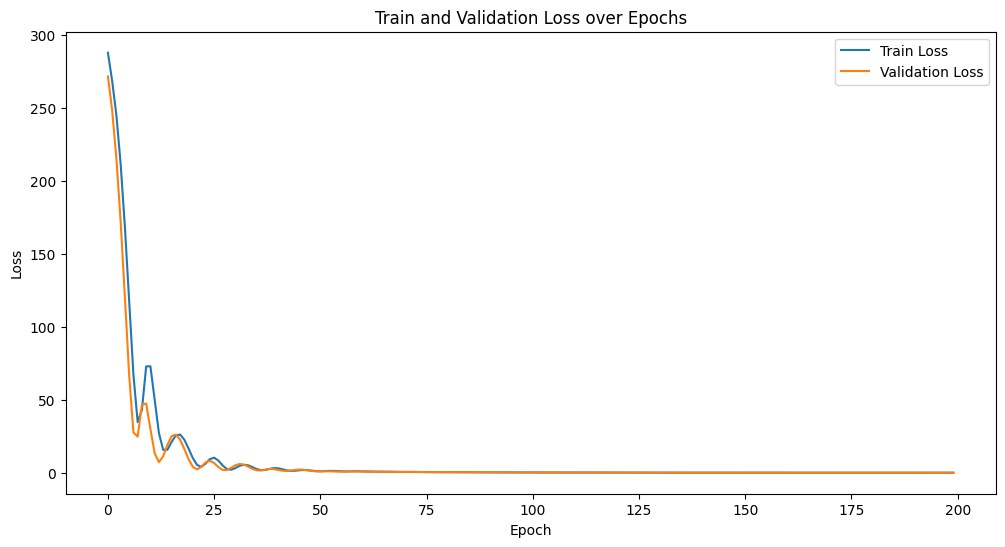

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

# Perte finale sur l'ensemble de validation

In [18]:
final_val_loss = val_losses[-1]
print(f'Final Validation Loss: {final_val_loss:.4f}')

Final Validation Loss: 0.0301


In [21]:
torch.save(model.state_dict(), '../../models/olympic_medals_ann.pth')
print('Model créé avec sucées')

Model créé avec sucées
